In [22]:
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path.cwd().resolve().parent

HR_DATA_ROOT = (
    PROJECT_ROOT
    / "repos"
    / "sr_nl"
    / "Hindmarsh-Rose-Codes"
    / "Data"
)

print("HR_DATA_ROOT:", HR_DATA_ROOT)


HR_DATA_ROOT: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/Hindmarsh-Rose-Codes/Data


In [13]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

plt.style.use("default")


In [14]:
def hindmarsh_rose_model(X, t, current, r, x1, a, b, c, d, s):
    x, y, z = X
    dxdt = y - a*x**3 + b*x**2 - z + current
    dydt = c - d*x**2 - y
    dzdt = r*(s*(x - x1) - z)
    return [dxdt, dydt, dzdt]


def hr_trajectory(X0, t_max, dt, current, r, x1, a, b, c, d, s):
    t = np.arange(0, t_max, dt)
    X = odeint(
        hindmarsh_rose_model,
        X0,
        t,
        args=(current, r, x1, a, b, c, d, s)
    )
    return t, X[:,0], X[:,1], X[:,2]


In [15]:
# Initial conditions
X0 = [0, 0, 0]

# HR parameters (from paper)
a = 1
b = 3
c = 1
d = 5
x1 = -8/5
s = 4

# Chaotic regime
current = 3.28
r = 0.0021

# Time settings
t_max = 2000
dt = 0.01


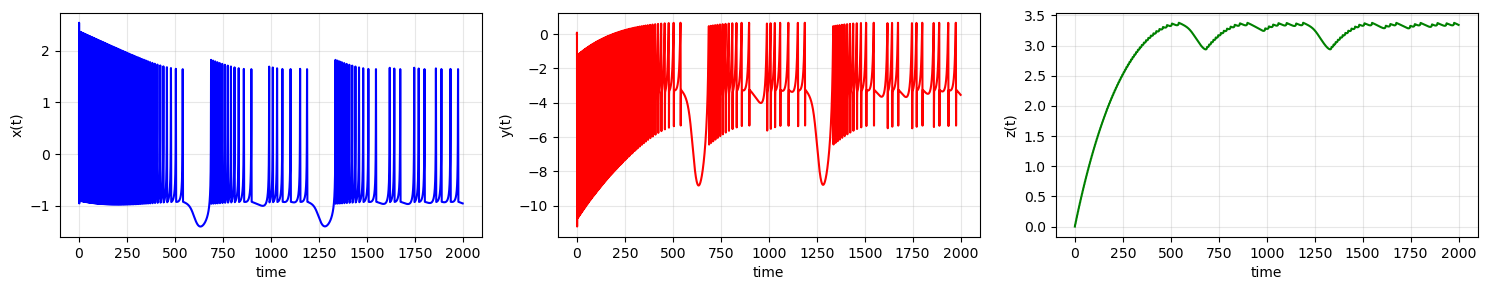

Saved to ../figures/HR_x_y_z.png


In [47]:
t, x, y, z = hr_trajectory(
    X0, t_max, dt,
    current, r, x1, a, b, c, d, s
)

fig, axes = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)

axes[0].plot(t, x, color='blue')
axes[0].set_xlabel("time")
axes[0].set_ylabel("x(t)")
axes[0].grid(alpha=0.3)

axes[1].plot(t, y, color='red')
axes[1].set_xlabel("time")
axes[1].set_ylabel("y(t)")
axes[1].grid(alpha=0.3)

axes[2].plot(t, z, color='green')
axes[2].set_xlabel("time")
axes[2].set_ylabel("z(t)")
axes[2].grid(alpha=0.3)

save_path = "../figures/HR_x_y_z.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


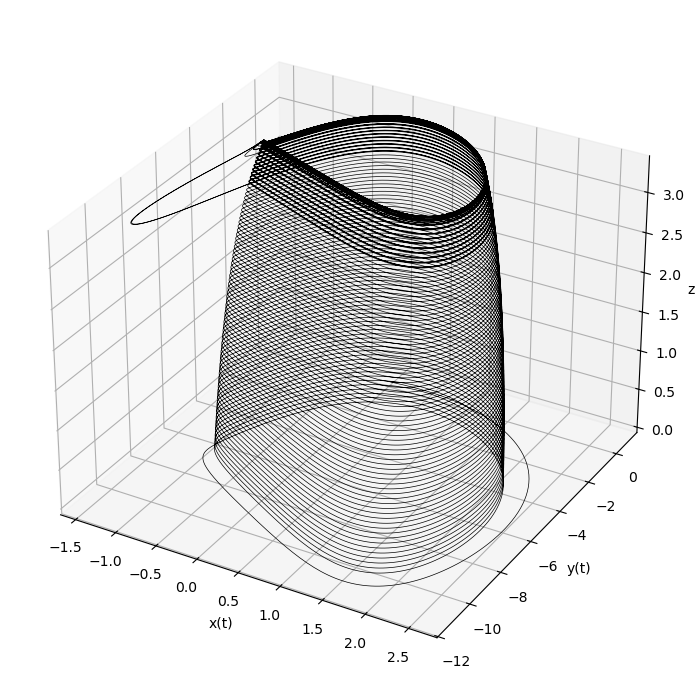

Saved to ../figures/HR_3D_x_y_z.png


In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, 'k', linewidth=0.5)
ax.set_xlabel("x(t)")
ax.set_ylabel("y(t)")
ax.set_zlabel("z(t)")

plt.tight_layout()
save_path = "../figures/HR_3D_x_y_z.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


In [18]:
x_norm = (x - x.min()) / (x.max() - x.min())
timeseries = x_norm.reshape(-1, 1)


In [24]:
DATA_NAME = "single_variable_classification"

DATA_DIR = HR_DATA_ROOT / DATA_NAME
print("DATA_DIR:", DATA_DIR)


DATA_DIR: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/Hindmarsh-Rose-Codes/Data/single_variable_classification


In [25]:
X_train = np.load(DATA_DIR / "traindata.npy")
y_train = np.load(DATA_DIR / "trainlabel.npy")

X_test  = np.load(DATA_DIR / "testdata.npy")
y_test  = np.load(DATA_DIR / "testlabel.npy")

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (200, 1) (200, 1)
Test:  (200, 1) (200, 1)


In [27]:
import numpy as np
import os

from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [28]:
def chaos_transform(X, timeseries, threshold, epsilon):
    """
    Feature extraction using chaotic time series
    """
    FEATURE_MATRIX = []

    for x in X:
        noisy_x = x + np.random.uniform(-epsilon, epsilon)
        idx = np.argmin(np.abs(timeseries - noisy_x))
        firing_time = idx / len(timeseries)
        firing_rate = np.mean(timeseries[idx:] > threshold)
        energy = np.sum(timeseries[idx:] ** 2)
        entropy = -np.sum(
            timeseries[idx:] * np.log(timeseries[idx:] + 1e-10)
        )

        FEATURE_MATRIX.append([
            firing_time,
            firing_rate,
            energy,
            entropy
        ])

    return np.array(FEATURE_MATRIX)


def chaosnet(FEATURE_MATRIX_TRAIN, Y_TRAIN, FEATURE_MATRIX_VAL):
    """
    Nearest mean classifier (as used by authors)
    """
    classes = np.unique(Y_TRAIN)
    mean_each_class = {}

    for c in classes:
        mean_each_class[c] = np.mean(
            FEATURE_MATRIX_TRAIN[Y_TRAIN.flatten() == c],
            axis=0
        )

    Y_PRED = []
    for x in FEATURE_MATRIX_VAL:
        distances = [
            np.linalg.norm(x - mean_each_class[c])
            for c in classes
        ]
        Y_PRED.append(classes[np.argmin(distances)])

    return mean_each_class, np.array(Y_PRED)


In [29]:
def k_cross_validation(
    FOLD_NO,
    traindata, trainlabel,
    testdata, testlabel,
    DISCRIMINATION_THRESHOLD,
    EPSILON,
    timeseries,
    DATA_NAME
):
    ACCURACY = np.zeros((len(DISCRIMINATION_THRESHOLD), len(EPSILON)))
    FSCORE = np.zeros((len(DISCRIMINATION_THRESHOLD), len(EPSILON)))

    B = np.zeros_like(FSCORE)
    EPS = np.zeros_like(FSCORE)

    KF = KFold(n_splits=FOLD_NO, shuffle=True, random_state=42)

    for i, DT in enumerate(DISCRIMINATION_THRESHOLD):
        for j, eps in enumerate(EPSILON):

            f1_scores = []

            for train_idx, val_idx in KF.split(traindata):
                X_TRAIN, X_VAL = traindata[train_idx], traindata[val_idx]
                Y_TRAIN, Y_VAL = trainlabel[train_idx], trainlabel[val_idx]

                FM_TRAIN = chaos_transform(X_TRAIN, timeseries, DT, eps)
                FM_VAL   = chaos_transform(X_VAL,   timeseries, DT, eps)

                _, Y_PRED = chaosnet(FM_TRAIN, Y_TRAIN, FM_VAL)

                f1 = f1_score(Y_VAL, Y_PRED, average="macro")
                f1_scores.append(f1)

            FSCORE[i, j] = np.mean(f1_scores)
            B[i, j] = DT
            EPS[i, j] = eps

            print(f"DT={DT:.2f}, eps={eps:.2f} → F1={FSCORE[i,j]:.3f}")

    print("BEST F1:", FSCORE.max())
    return FSCORE, B, EPS, EPSILON


In [31]:
# ================================
# Parameters for SR experiment
# ================================

# Cross-validation
FOLD_NO = 5

# Dataset name (for logging only)
DATA_NAME = "single_variable_classification"

# Discrimination threshold (as in the paper)
DISCRIMINATION_THRESHOLD = [0.89]

# Noise intensity sweep
EPSILON = np.arange(0.01, 1.01, 0.01)

print("Running SR with parameters:")
print("FOLD_NO =", FOLD_NO)
print("DISCRIMINATION_THRESHOLD =", DISCRIMINATION_THRESHOLD)
print("EPSILON range =", EPSILON[0], "→", EPSILON[-1])

# ================================
# Run cross-validation
# ================================

FSCORE, B, EPS, EPSILON_USED = k_cross_validation(
    FOLD_NO,
    X_train, y_train,
    X_test, y_test,
    DISCRIMINATION_THRESHOLD,
    EPSILON,
    timeseries,
    DATA_NAME
)


Running SR with parameters:
FOLD_NO = 5
DISCRIMINATION_THRESHOLD = [0.89]
EPSILON range = 0.01 → 1.0
DT=0.89, eps=0.01 → F1=0.623
DT=0.89, eps=0.02 → F1=0.571
DT=0.89, eps=0.03 → F1=0.625
DT=0.89, eps=0.04 → F1=0.674
DT=0.89, eps=0.05 → F1=0.637
DT=0.89, eps=0.06 → F1=0.648
DT=0.89, eps=0.07 → F1=0.613
DT=0.89, eps=0.08 → F1=0.631
DT=0.89, eps=0.09 → F1=0.627
DT=0.89, eps=0.10 → F1=0.686
DT=0.89, eps=0.11 → F1=0.604
DT=0.89, eps=0.12 → F1=0.623
DT=0.89, eps=0.13 → F1=0.636
DT=0.89, eps=0.14 → F1=0.621
DT=0.89, eps=0.15 → F1=0.652
DT=0.89, eps=0.16 → F1=0.661
DT=0.89, eps=0.17 → F1=0.658
DT=0.89, eps=0.18 → F1=0.701
DT=0.89, eps=0.19 → F1=0.671
DT=0.89, eps=0.20 → F1=0.722
DT=0.89, eps=0.21 → F1=0.605
DT=0.89, eps=0.22 → F1=0.692
DT=0.89, eps=0.23 → F1=0.594
DT=0.89, eps=0.24 → F1=0.648
DT=0.89, eps=0.25 → F1=0.662
DT=0.89, eps=0.26 → F1=0.693
DT=0.89, eps=0.27 → F1=0.623
DT=0.89, eps=0.28 → F1=0.734
DT=0.89, eps=0.29 → F1=0.618
DT=0.89, eps=0.30 → F1=0.618
DT=0.89, eps=0.31 → F1=0.688


In [32]:
print("FSCORE shape:", FSCORE.shape)
print("Max F1-score:", FSCORE.max())

best_idx = np.argmax(FSCORE[0])
print("Best epsilon:", EPSILON[best_idx])


FSCORE shape: (1, 100)
Max F1-score: 0.768278267434305
Best epsilon: 0.45


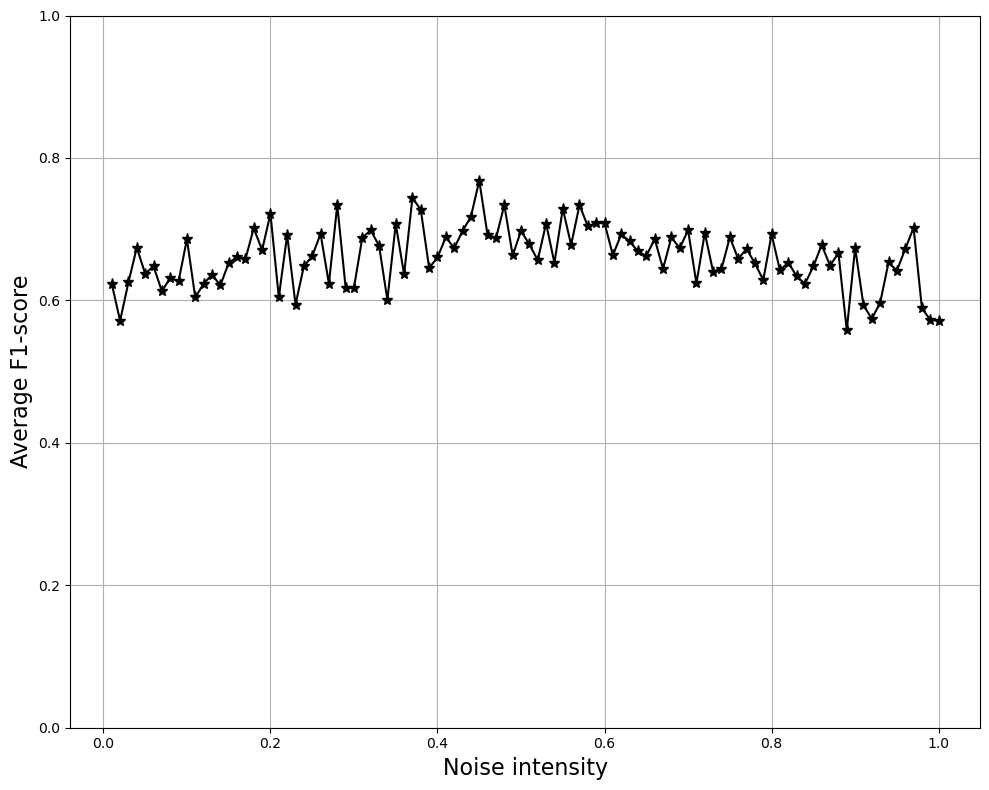

In [33]:
plt.figure(figsize=(10, 8))

plt.plot(
    EPSILON,
    FSCORE[0],
    '-*k',
    markersize=8,
    linewidth=1.5
)

plt.xlabel("Noise intensity", fontsize=16)
plt.ylabel("Average F1-score", fontsize=16)
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

# Root of your project: .../CHAOS_NET
PROJECT_ROOT = Path.cwd().resolve().parent

# Repo folder where Codes.py lives
HR_REPO = PROJECT_ROOT / "repos" / "sr_nl" / "Hindmarsh-Rose-Codes"
DATA_ROOT = HR_REPO / "Data"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("HR_REPO:", HR_REPO)
print("DATA_ROOT:", DATA_ROOT)

# Make sure Python can import Codes.py from Hindmarsh-Rose-Codes
sys.path.insert(0, str(HR_REPO))


PROJECT_ROOT: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net
HR_REPO: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/Hindmarsh-Rose-Codes
DATA_ROOT: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/Hindmarsh-Rose-Codes/Data


In [35]:
DATA_NAME = "single_variable_classification"  # в их репо это и есть то, что в статье называют prey–predator
DATA_DIR = DATA_ROOT / DATA_NAME
print("DATA_DIR:", DATA_DIR)

X_train = np.load(DATA_DIR / "traindata.npy")
y_train = np.load(DATA_DIR / "trainlabel.npy")
X_test  = np.load(DATA_DIR / "testdata.npy")
y_test  = np.load(DATA_DIR / "testlabel.npy")

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

# На всякий случай приводим labels к 1D (часто лежат (N,1))
y_train = y_train.reshape(-1)
y_test  = y_test.reshape(-1)

print("Labels unique train:", np.unique(y_train))
print("Labels unique test:", np.unique(y_test))


DATA_DIR: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/Hindmarsh-Rose-Codes/Data/single_variable_classification
Train: (200, 1) (200, 1)
Test:  (200, 1) (200, 1)
Labels unique train: [0. 1.]
Labels unique test: [0. 1.]


In [50]:
def k_cross_validation(FOLD_NO, traindata, trainlabel, testdata, testlabel, INITIAL_NEURAL_ACTIVITY, DISCRIMINATION_THRESHOLD, EPSILON, DATA_NAME):
    """

    Parameters
    ----------
    FOLD_NO : TYPE-Integer
        DESCRIPTION-K fold classification.
    traindata : TYPE-numpy 2D array
        DESCRIPTION - Traindata
    trainlabel : TYPE-numpy 2D array
        DESCRIPTION - Trainlabel
    testdata : TYPE-numpy 2D array
        DESCRIPTION - Testdata
    testlabel : TYPE - numpy 2D array
        DESCRIPTION - Testlabel
    INITIAL_NEURAL_ACTIVITY : TYPE - numpy 1D array
        DESCRIPTION - initial value of the chaotic skew tent map.
    DISCRIMINATION_THRESHOLD : numpy 1D array
        DESCRIPTION - thresholds of the chaotic map
    EPSILON : TYPE numpy 1D array
        DESCRIPTION - noise intenity for NL to work (low value of epsilon implies low noise )
    DATA_NAME : TYPE - string
        DESCRIPTION.

    Returns
    -------
    FSCORE, Q, B, EPS, EPSILON

    """
    ACCURACY = np.zeros((len(DISCRIMINATION_THRESHOLD), len(INITIAL_NEURAL_ACTIVITY),  len(EPSILON)))
    FSCORE = np.zeros((len(DISCRIMINATION_THRESHOLD), len(INITIAL_NEURAL_ACTIVITY),  len(EPSILON)))
    Q = np.zeros((len(DISCRIMINATION_THRESHOLD), len(INITIAL_NEURAL_ACTIVITY),  len(EPSILON)))
    B = np.zeros((len(DISCRIMINATION_THRESHOLD), len(INITIAL_NEURAL_ACTIVITY),  len(EPSILON)))
    EPS = np.zeros((len(DISCRIMINATION_THRESHOLD), len(INITIAL_NEURAL_ACTIVITY),  len(EPSILON)))


    KF = KFold(n_splits= FOLD_NO, random_state=42, shuffle=True) # Define the split - into 2 folds 
    KF.get_n_splits(traindata) # returns the number of splitting iterations in the cross-validator
    print(KF) 
    
    ROW = -1
    COL = -1
    WIDTH = -1
    for DT in DISCRIMINATION_THRESHOLD:
        ROW = ROW+1
        COL = -1
        WIDTH = -1
        for INA in INITIAL_NEURAL_ACTIVITY:
            COL =COL+1
            WIDTH = -1
            for EPSILON_1 in EPSILON:
                WIDTH = WIDTH + 1
                
                ACC_TEMP =[]
                FSCORE_TEMP=[]
            
                for TRAIN_INDEX, VAL_INDEX in KF.split(traindata):
                    
                    X_TRAIN, X_VAL = traindata[TRAIN_INDEX], traindata[VAL_INDEX]
                    Y_TRAIN, Y_VAL = trainlabel[TRAIN_INDEX], trainlabel[VAL_INDEX]
        

                    # Extract features
                    FEATURE_MATRIX_TRAIN = CFX.transform(X_TRAIN, INA, 10000, EPSILON_1, DT)
                    FEATURE_MATRIX_VAL = CFX.transform(X_VAL, INA, 10000, EPSILON_1, DT)            
                
                   
                    mean_each_class, Y_PRED = chaosnet(FEATURE_MATRIX_TRAIN,Y_TRAIN, FEATURE_MATRIX_VAL)
                    
                    ACC = accuracy_score(Y_VAL, Y_PRED)*100
                    RECALL = recall_score(Y_VAL, Y_PRED , average="macro")
                    PRECISION = precision_score(Y_VAL, Y_PRED , average="macro")
                    F1SCORE = f1_score(Y_VAL, Y_PRED, average="macro")
                                 
                    
                    ACC_TEMP.append(ACC)
                    FSCORE_TEMP.append(F1SCORE)
                Q[ROW, COL, WIDTH ] = INA # Initial Neural Activity
                B[ROW, COL, WIDTH ] = DT # Discrimination Threshold
                EPS[ROW, COL, WIDTH ] = EPSILON_1 
                ACCURACY[ROW, COL, WIDTH ] = np.mean(ACC_TEMP)
                FSCORE[ROW, COL, WIDTH ] = np.mean(FSCORE_TEMP)
                #print("Mean F1-Score for Q = ", Q[ROW, COL, WIDTH ],"B = ", B[ROW, COL, WIDTH ],"EPSILON = ", EPS[ROW, COL, WIDTH ]," is  = ",  np.mean(FSCORE_TEMP)  )
    
    print("Saving Hyperparameter Tuning Results")
    
    
    PATH = os.getcwd()
    RESULT_PATH = PATH + '/SR-PLOTS/'  + DATA_NAME + '/NEUROCHAOS-RESULTS/'
    
    
    try:
        os.makedirs(RESULT_PATH)
    except OSError:
        print ("Creation of the result directory %s failed" % RESULT_PATH)
    else:
        print ("Successfully created the result directory %s" % RESULT_PATH)
    
    np.save(RESULT_PATH+"/h_fscore.npy", FSCORE )    
    np.save(RESULT_PATH+"/h_accuracy.npy", ACCURACY ) 
    np.save(RESULT_PATH+"/h_Q.npy", Q ) 
    np.save(RESULT_PATH+"/h_B.npy", B )
    np.save(RESULT_PATH+"/h_EPS.npy", EPS )               
    
    
    MAX_FSCORE = np.max(FSCORE)
    Q_MAX = []
    B_MAX = []
    EPSILON_MAX = []
    
    for ROW in range(0, len(DISCRIMINATION_THRESHOLD)):
        for COL in range(0, len(INITIAL_NEURAL_ACTIVITY)):
            for WID in range(0, len(EPSILON)):
                if FSCORE[ROW, COL, WID] == MAX_FSCORE:
                    Q_MAX.append(Q[ROW, COL, WID])
                    B_MAX.append(B[ROW, COL, WID])
                    EPSILON_MAX.append(EPS[ROW, COL, WID])
    
    print("BEST F1SCORE", MAX_FSCORE)
    print("BEST INITIAL NEURAL ACTIVITY = ", Q_MAX)
    print("BEST DISCRIMINATION THRESHOLD = ", B_MAX)
    print("BEST EPSILON = ", EPSILON_MAX)
    return FSCORE, Q, B, EPS, EPSILON
    



In [49]:
FOLD_NO = 5

INITIAL_NEURAL_ACTIVITY = [0.25]
DISCRIMINATION_THRESHOLD = [0.89]
EPSILON = np.arange(0.01, 1.01, 0.01)

print("FOLD_NO:", FOLD_NO)
print("INITIAL_NEURAL_ACTIVITY:", INITIAL_NEURAL_ACTIVITY)
print("DISCRIMINATION_THRESHOLD:", DISCRIMINATION_THRESHOLD)
print("EPSILON:", EPSILON[0], "→", EPSILON[-1], "step", EPSILON[1]-EPSILON[0], "len", len(EPSILON))



FOLD_NO: 5
INITIAL_NEURAL_ACTIVITY: [0.25]
DISCRIMINATION_THRESHOLD: [0.89]
EPSILON: 0.01 → 1.0 step 0.01 len 100


In [42]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
SR_PATH = PROJECT_ROOT / "repos" / "sr_nl"

sys.path.append(str(SR_PATH))

import ChaosFEX.feature_extractor as CFX

print("ChaosFEX loaded from:", CFX.__file__)

> Numba JIT warmup successful for chaotic_sampler ...
> Numba JIT warmup successful for transform ...
ChaosFEX loaded from: /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/repos/sr_nl/ChaosFEX/feature_extractor.py


In [51]:
FSCORE, Q, B, EPS, EPSILON_USED = k_cross_validation(
    FOLD_NO,
    X_train, y_train,
    X_test, y_test,
    INITIAL_NEURAL_ACTIVITY,
    DISCRIMINATION_THRESHOLD,
    EPSILON,
    DATA_NAME
)

print("FSCORE shape:", np.array(FSCORE).shape)
print("Max F1:", np.max(FSCORE))


KFold(n_splits=5, random_state=42, shuffle=True)


/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

Saving Hyperparameter Tuning Results
Creation of the result directory /Users/aleksandrasuvorova/Documents/GitHub/ML-tasks/Chaos_Net/notebooks/SR-PLOTS/single_variable_classification/NEUROCHAOS-RESULTS/ failed
BEST F1SCORE 0.9187553527623613
BEST INITIAL NEURAL ACTIVITY =  [np.float64(0.25)]
BEST DISCRIMINATION THRESHOLD =  [np.float64(0.89)]
BEST EPSILON =  [np.float64(0.26)]
FSCORE shape: (1, 1, 100)
Max F1: 0.9187553527623613


/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniconda/base/envs/conda_ipynb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

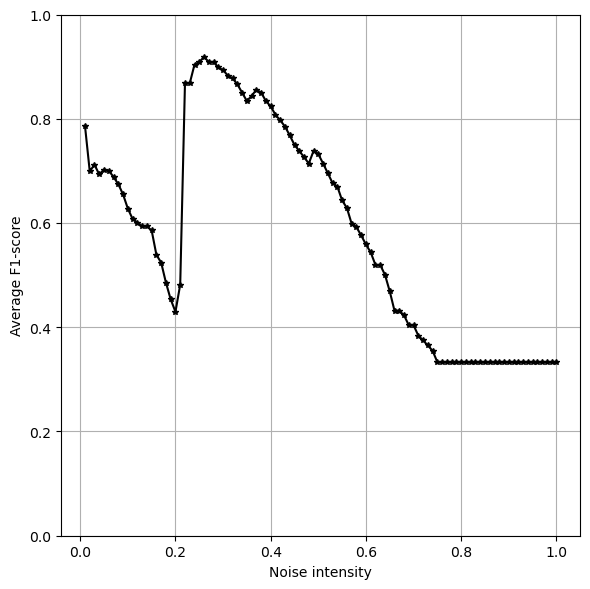

Saved to ../figures/HR_prey_predator_fig_11.png


In [52]:
plt.figure(figsize=(6, 6))
plt.plot(EPSILON_USED, FSCORE[0, 0, :], "-*k", markersize=4)
plt.grid(True)
plt.xlabel("Noise intensity")
plt.ylabel("Average F1-score")
plt.ylim(0, 1)
save_path = "../figures/HR_prey_predator_fig_11.png"
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Saved to {save_path}")


In [53]:
curve = FSCORE[0, 0, :]
best_i = int(np.argmax(curve))
print("Best epsilon:", EPSILON_USED[best_i])
print("Best F1:", curve[best_i])


Best epsilon: 0.26
Best F1: 0.9187553527623613


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# x(t) из HR (уже посчитан ранее)
x_ts = x.copy()

# убираем транзиент (очень важно!)
transient = int(0.2 * len(x_ts))
x_ts = x_ts[transient:]

# нормализация (необязательно, но стабилизирует)
x_ts = (x_ts - np.mean(x_ts)) / np.std(x_ts)

print("Length of x(t):", len(x_ts))


Length of x(t): 160000


In [85]:
from scipy.spatial import cKDTree

def lyapunov_rosenstein(x, dt, emb_dim=6, tau=10, max_t=200):
    """
    Estimate largest Lyapunov exponent using Rosenstein method.
    
    Parameters:
    x       : 1D time series
    dt      : time step
    emb_dim : embedding dimension
    tau     : delay
    max_t   : max evolution steps
    
    Returns:
    t_vals, avg_log_divergence
    """
    N = len(x) - (emb_dim - 1) * tau
    if N <= max_t:
        raise ValueError("Time series too short for given parameters")

    # Phase space reconstruction
    Y = np.array([x[i:i + emb_dim * tau:tau] for i in range(N)])

    tree = cKDTree(Y)

    # Find nearest neighbors with temporal separation
    neighbors = []
    for i in range(N):
        dists, idxs = tree.query(Y[i], k=10)
        for j in idxs:
            if abs(j - i) > tau:
                neighbors.append((i, j))
                break

    neighbors = np.array(neighbors)
    M = len(neighbors)

    divergence = np.zeros(max_t)

    for k in range(max_t):
        valid = (neighbors[:, 0] + k < N) & (neighbors[:, 1] + k < N)
        if not np.any(valid):
            break

        dist = np.linalg.norm(
            Y[neighbors[valid, 0] + k] - Y[neighbors[valid, 1] + k],
            axis=1
        )

        divergence[k] = np.log(np.mean(dist) + 1e-10)


    t_vals = np.arange(max_t) * dt
    return t_vals, divergence


In [86]:
dt = 0.01  # как в HR
t_vals, log_div = lyapunov_rosenstein(
    x_ts,
    dt=dt,
    emb_dim=6,
    tau=10,
    max_t=2500
)


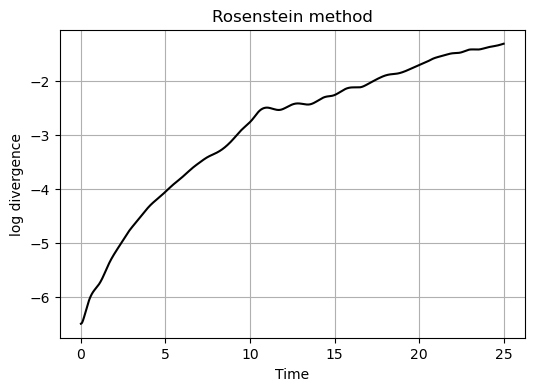

In [87]:


fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(t_vals, log_div, 'k')
ax.set_xlabel("Time")
ax.set_ylabel("log divergence")
ax.set_title("Rosenstein method")

#ax.set_xscale('log')   # ← ВОТ ЗДЕСЬ
ax.grid(True)

plt.show()



In [88]:
# выбираем линейный интервал (подбирается визуально)
fit_start = 20
fit_end = 120

coeffs = np.polyfit(
    t_vals[fit_start:fit_end],
    log_div[fit_start:fit_end],
    1
)

lambda_est = coeffs[0]

print("Estimated Lyapunov exponent λ ≈", lambda_est)


Estimated Lyapunov exponent λ ≈ 0.6115519756198602


In [89]:
# --- выбор линейного участка ---
fit_start = 30
fit_end   = 120

t_fit = t_vals[fit_start:fit_end]
log_fit = log_div[fit_start:fit_end]

# --- линейная аппроксимация ---
coeffs = np.polyfit(t_fit, log_fit, 1)
lambda_est = coeffs[0]
intercept = coeffs[1]

print("Estimated Lyapunov exponent λ =", lambda_est)

# --- линия тренда ---
log_fit_line = intercept + lambda_est * t_fit


Estimated Lyapunov exponent λ = 0.553541486721044


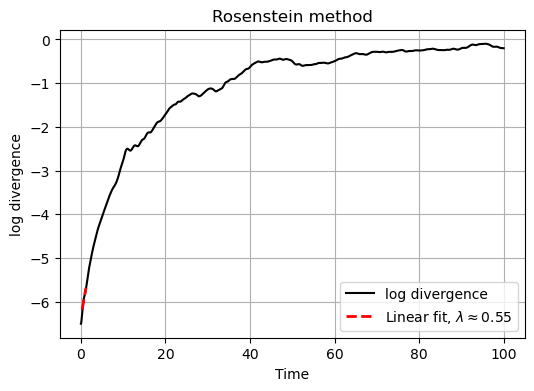

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))

# исходная кривая
ax.plot(t_vals, log_div, 'k', label='log divergence')

# линейный тренд
ax.plot(
    t_fit,
    log_fit_line,
    'r--',
    linewidth=2,
    label=rf'Linear fit, $\lambda \approx {lambda_est:.2f}$'
)

ax.set_xlabel("Time")
ax.set_ylabel("log divergence")
ax.set_title("Rosenstein method")

#ax.set_xscale('log')   # лог-шкала ТОЛЬКО для визуализации
ax.grid(True)
ax.legend()

plt.show()
